<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston


boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [3]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [4]:
#Check for null value in features
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [5]:
#Check for null value in target variable
y.isnull().sum()

MEDV    0
dtype: int64

In [6]:
X.index

RangeIndex(start=0, stop=506, step=1)

In [7]:
y.index

RangeIndex(start=0, stop=506, step=1)

In [8]:
#Checking for feature datatype, looks ok with the only possible change is to change CHAS from float to integer. However,
#there should not be any difference in our analysis, it will be kept as float
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [9]:
#Checking for target datatype; datatype is as expected
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
MEDV    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


In [10]:
#Checking for the shape of the feature set
X.shape

(506, 13)

In [11]:
#Checking for the shape of the target set. Same number of rows as feature. No change required
y.shape

(506, 1)

In [12]:
#Checking descriptive stats for any unusual case
X.describe()
#Maximum crime rate by town seems high and minimum  of proportion of black seems low, these might be an outliers

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [13]:
X[X['CRIM']>50]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
380,88.9762,0.0,18.1,0.0,0.671,6.968,91.9,1.4165,24.0,666.0,20.2,396.90,17.21
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98
410,51.1358,0.0,18.1,0.0,0.597,5.757,100.0,1.4130,24.0,666.0,20.2,2.60,10.11
418,73.5341,0.0,18.1,0.0,0.679,5.957,100.0,1.8026,24.0,666.0,20.2,16.45,20.62


In [14]:
X[X['B']<10]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
410,51.13580,0.0,18.1,0.0,0.597,5.757,100.0,1.4130,24.0,666.0,20.2,2.60,10.11
423,7.05042,0.0,18.1,0.0,0.614,6.103,85.1,2.0218,24.0,666.0,20.2,2.52,23.29
424,8.79212,0.0,18.1,0.0,0.584,5.565,70.6,2.0635,24.0,666.0,20.2,3.65,17.16
425,15.86030,0.0,18.1,0.0,0.679,5.896,95.4,1.9096,24.0,666.0,20.2,7.68,24.39
437,15.17720,0.0,18.1,0.0,0.740,6.152,100.0,1.9142,24.0,666.0,20.2,9.32,26.45
450,6.71772,0.0,18.1,0.0,0.713,6.749,92.6,2.3236,24.0,666.0,20.2,0.32,17.44
454,9.51363,0.0,18.1,0.0,0.713,6.728,94.1,2.4961,24.0,666.0,20.2,6.68,18.71
457,8.20058,0.0,18.1,0.0,0.713,5.936,80.3,2.7792,24.0,666.0,20.2,3.50,16.94


In [15]:
#As both suspected fetature have data in the same range as the minimum and maximum value, fair to assume they are not outlier

In [16]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [17]:
predictor = ['DIS', 'CRIM', 'LSTAT', 'PTRATIO']

In [18]:
X_model = X[predictor]

In [19]:
lr = LinearRegression()
lr.fit(X_model,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
print(lr.intercept_)
print(lr.coef_)
#Based on the model, a one point increase in weighted distance from employment center leads to a $803 drop in median value
# A one point increase in per capitat crime rate leads to a $64 decrease in media value
#A one point increase in the percentage of lower status of the population leads to a $901 drop in median value
#and a one point increase in Pupil Teacher ratio leads to a $1,151 decrease in median value

[58.48943351]
[[-0.80384039 -0.06473552 -0.90197643 -1.15199107]]


Based on the model, a one point increase in weighted distance from employment center leads to a 803 dollar drop in median value, a one point increase in per capitat crime rate leads to a 64 dollar decrease in median value, a one point increase in the percentage of lower status of the population leads to a 901 dollardrop in median value and a one point increase in Pupil Teacher ratio leads to a 1,151 dollar decreasese in median value

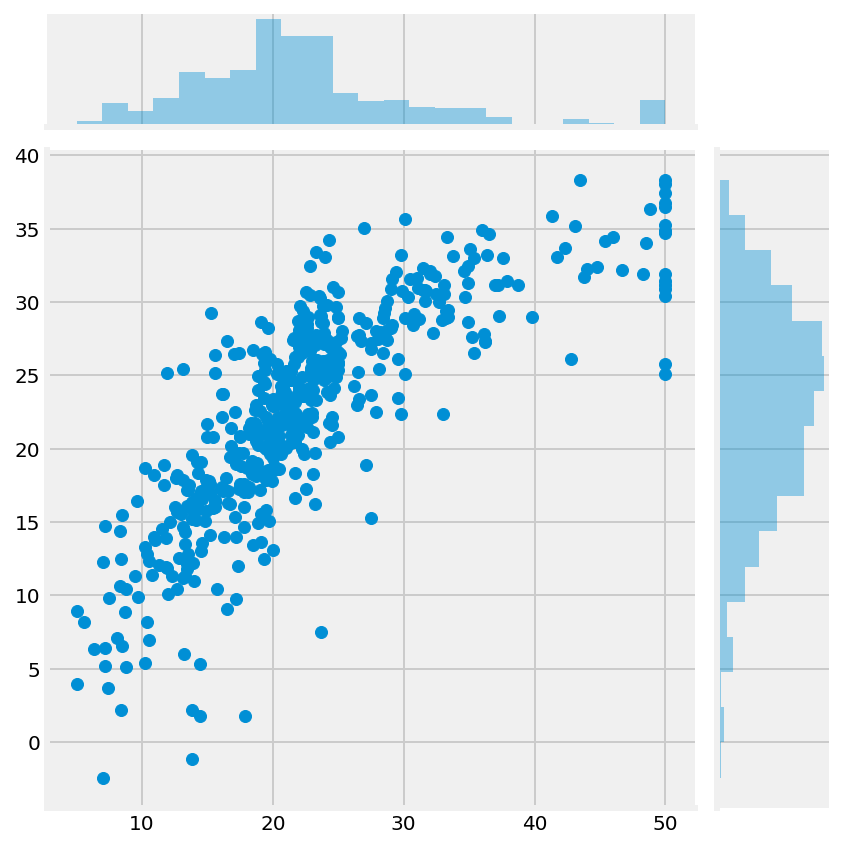

In [21]:
y_hat = lr.predict(X_model)
sns.jointplot(y, y_hat,stat_func=None);

In [22]:
print(metrics.mean_squared_error(y,y_hat))

31.095175560224437


### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y, train_size=0.7, random_state=123)
linreg = LinearRegression()
linreg.fit(X_train,y_train)

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

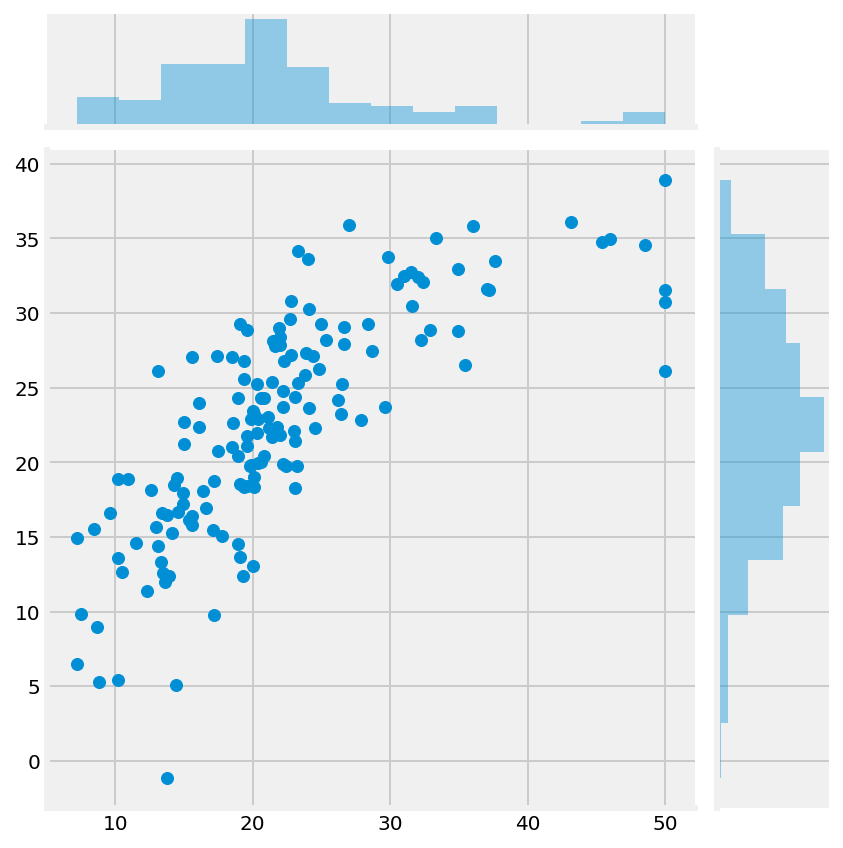

In [24]:
yhat = linreg.predict(X_test)
sns.jointplot(y_test, yhat);
#I have no idea why the error is out, I know that it has something to do with the stat_func but is unable to solve it
#apart from changing to stat_func = None


In [25]:
print(metrics.mean_squared_error(y_train,linreg.predict(X_train)))
print(metrics.mean_squared_error(y_test,yhat))

29.95976370382279
34.12298151031599


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_model, y, train_size=0.9, random_state=123)
linreg = LinearRegression()
linreg.fit(X_train,y_train)

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

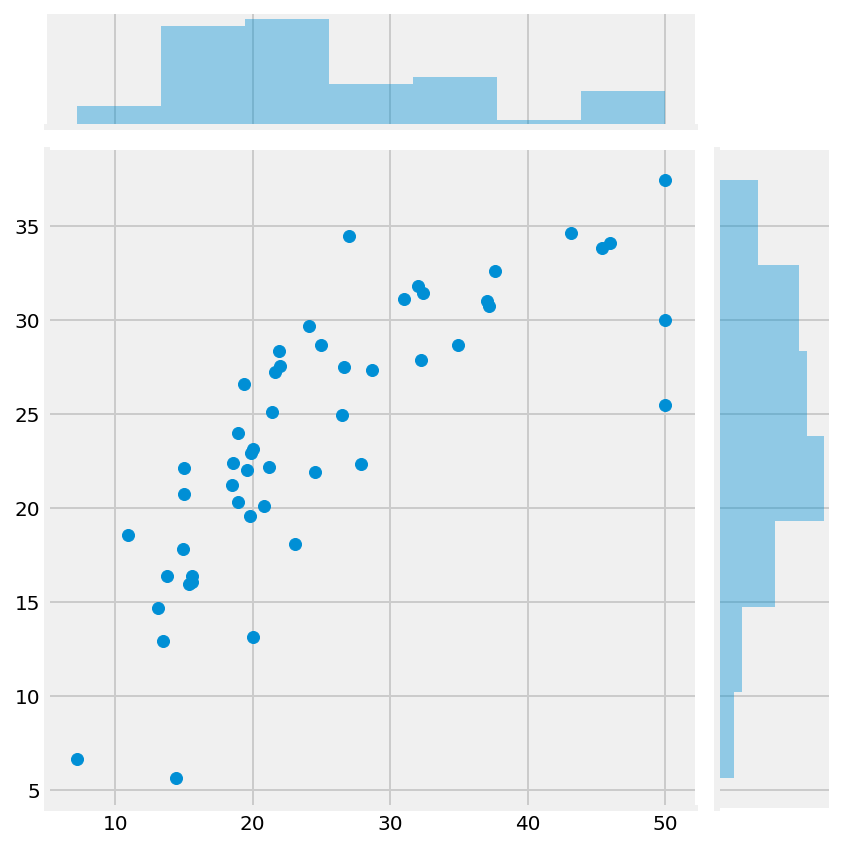

In [27]:
yhat = linreg.predict(X_test)
sns.jointplot(y_test, yhat,stat_func=None);

In [28]:
print(metrics.mean_squared_error(y_train,linreg.predict(X_train)))
print(metrics.mean_squared_error(y_test,yhat))

29.452993486498848
46.422653417465824


As the training size increases, the mean square error increases. This is due to overfitting of the model to the training set leading it to have a high bias and hence the increase in error

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [29]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [30]:
for fold in range(5,11):
    print(' ')
    print ('fold = ' + str(fold))
    lr = LinearRegression()
    score = cross_val_score(lr,X_model,y,cv =fold)
    MSE = cross_val_score(lr,X_model,y,cv =fold,scoring= 'neg_mean_squared_error')
    print("Mean CV R2: {}".format(np.mean(score)))
    print('Std CV R2: {}'.format(np.std(score)))
    print("Mean CV MSE: {}".format(np.mean(MSE)))

 
fold = 5
Mean CV R2: 0.42331426278620066
Std CV R2: 0.10104355809422981
Mean CV MSE: -35.55617788366452
 
fold = 6
Mean CV R2: 0.4177239998417062
Std CV R2: 0.08152136179203505
Mean CV MSE: -36.03087651979504
 
fold = 7
Mean CV R2: 0.3889978353656301
Std CV R2: 0.12177778171565116
Mean CV MSE: -34.39367379620519
 
fold = 8
Mean CV R2: 0.20021760253879797
Std CV R2: 0.5396529493337849
Mean CV MSE: -37.57123713084782
 
fold = 9
Mean CV R2: 0.3221284863140881
Std CV R2: 0.24542476620012868
Mean CV MSE: -34.632307424802214
 
fold = 10
Mean CV R2: 0.03692939571410973
Std CV R2: 0.7155462815883038
Mean CV MSE: -33.342216701525345


# KNN Practice

In [31]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [32]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [33]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [34]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [35]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES


In [36]:

iris.loc[iris['species'] == 'Iris-setosa', 'species_num'] = 0
iris.loc[iris['species'] == 'Iris-versicolor', 'species_num'] = 1
iris.loc[iris['species'] == 'Iris-virginica', 'species_num'] = 2        

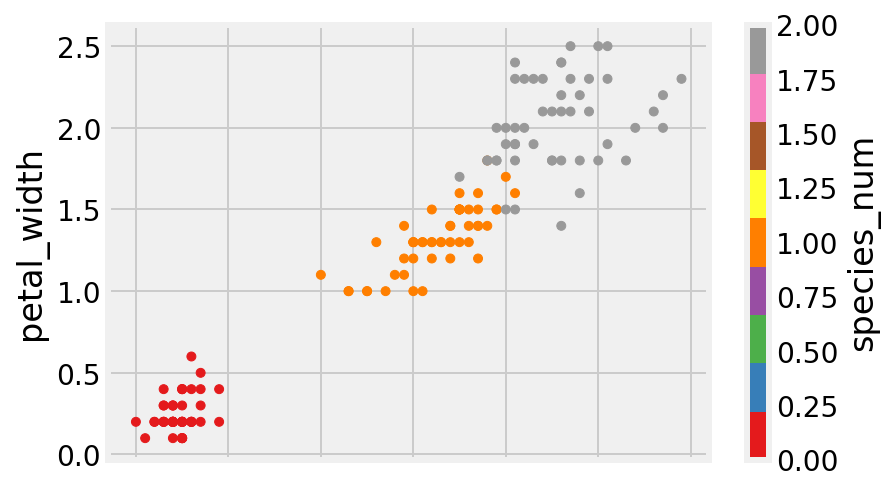

In [37]:
iris.plot(kind = 'scatter', x = 'petal_length', y = 'petal_width', c='species_num', colormap='Set1')

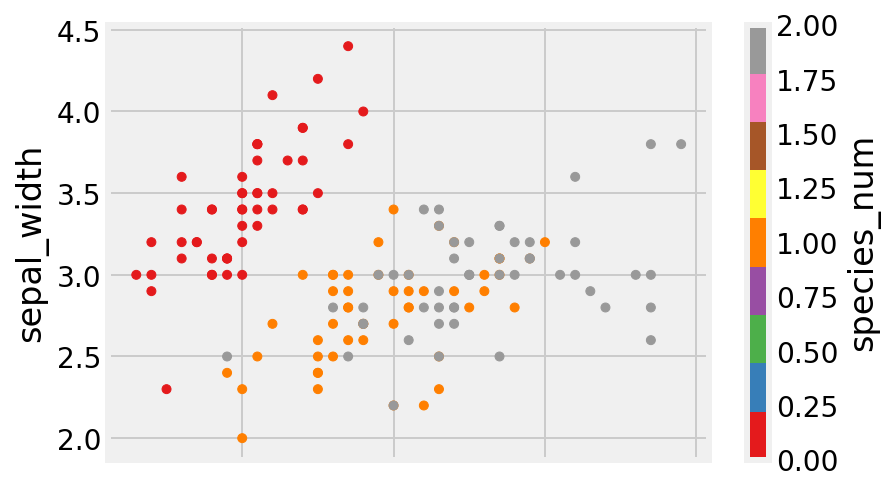

In [38]:
iris.plot(kind = 'scatter', x = 'sepal_length', y = 'sepal_width', c='species_num', colormap='Set1')

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [39]:
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

### Create your target vector "y"
This will be the species type.

In [40]:
y = iris['species_num']

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [43]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [44]:
y_pred = knn.predict(X_test)

In [45]:
print(metrics.accuracy_score(y_test,y_pred))

0.9111111111111111


### Create a Model With Five Neighbors. Did it Improve?

In [46]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
y_pred = knn_5.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))

0.9777777777777777


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [47]:
for k in range (1,101):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    print(str(k) + " :" + str(metrics.accuracy_score(y_test,y_pred)))

1 :0.9111111111111111
2 :0.9111111111111111
3 :0.9555555555555556
4 :0.9555555555555556
5 :0.9777777777777777
6 :0.9555555555555556
7 :0.9777777777777777
8 :0.9555555555555556
9 :0.9555555555555556
10 :0.9555555555555556
11 :0.9777777777777777
12 :0.9777777777777777
13 :0.9777777777777777
14 :0.9555555555555556
15 :0.9777777777777777
16 :0.9555555555555556
17 :0.9555555555555556
18 :0.8888888888888888
19 :0.9111111111111111
20 :0.9111111111111111
21 :0.9111111111111111
22 :0.8888888888888888
23 :0.8888888888888888
24 :0.8888888888888888
25 :0.9111111111111111
26 :0.8888888888888888
27 :0.9111111111111111
28 :0.8888888888888888
29 :0.9111111111111111
30 :0.9111111111111111
31 :0.9111111111111111
32 :0.8888888888888888
33 :0.8888888888888888
34 :0.8666666666666667
35 :0.8666666666666667
36 :0.8666666666666667
37 :0.8666666666666667
38 :0.8666666666666667
39 :0.8666666666666667
40 :0.8666666666666667
41 :0.8666666666666667
42 :0.8666666666666667
43 :0.8666666666666667
44 :0.86666666666666

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [48]:
#It returns the probability of the observation being in the resepective target class

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))